In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os

import numpy as np

import matplotlib.pyplot as plt

from absl import logging

In [3]:
!pip install tensorflow-gpu==1.14.0
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
#tf.compat.v1.enable_eager_execution()
print(tf.__version__)
keras = tf.keras

     |████████████████████████████████| 377.0MB 84kB/s 
1.14.0


In [4]:
!ls

sample_data


In [5]:
!rm -rf privacy
!git clone https://github.com/weiyangwang/privacy

Cloning into 'privacy'...
remote: Enumerating objects: 877, done.
remote: Total 877 (delta 0), reused 0 (delta 0), pack-reused 877
Receiving objects: 100% (877/877), 332.86 KiB | 1.18 MiB/s, done.
Resolving deltas: 100% (554/554), done.


In [6]:
!ls

privacy  sample_data


In [7]:
%%bash
cd privacy
pip install -e .

Obtaining file:///content/privacy
  Running setup.py develop for privacy


In [0]:
os.chdir('privacy')

In [9]:
from distutils.version import LooseVersion

import numpy as np

from privacy.analysis.rdp_accountant import compute_rdp
from privacy.analysis.rdp_accountant import get_privacy_spent
from privacy.optimizers.dp_optimizer import DPGradientDescentGaussianOptimizer

if LooseVersion(tf.__version__) < LooseVersion('2.0.0'):
  log = tf.logging
  GradientDescentOptimizer = tf.train.GradientDescentOptimizer
  #tf.enable_eager_execution()
else:
  log = logging
  GradientDescentOptimizer = keras.optimizers.SGD  

learning_rate = 0.15
noise_multiplier = 1.1  #Ratio of the standard deviation to the clipping norm
l2_norm_clip = 1.0 #Clipping norm
batch_size = 250
epochs = 60
microbatches = 250

log.set_verbosity(log.INFO)

W0905 09:13:58.684431 140216468879232 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0905 09:13:58.698832 140216468879232 deprecation_wrapper.py:119] From /content/privacy/privacy/optimizers/dp_optimizer.py:228: The name tf.train.AdagradOptimizer is deprecated. Please use tf.compat.v1.train.AdagradOptimizer instead.

W0905 09:13:58.699695 140216468879232 deprecation_wrapper.py:119] From /content/privacy/privacy/optimizers/dp_optimizer.py:229: The name tf.train.AdamOptimizer is deprecated. Please use tf.compat.v1.train.AdamOptimizer instead.

W0905 09:13:58.700414 140216468879232 deprecation_wrapper.py:119] From /content/privacy/privacy/optimizers/dp_opti

In [0]:
def compute_epsilon(steps):
  """Computes epsilon value for given hyperparameters."""
  if noise_multiplier == 0.0:
    return float('inf')
  orders = [1 + x / 10. for x in range(1, 100)] + list(range(12, 64))
  sampling_probability = batch_size / 60000
  rdp = compute_rdp(q=sampling_probability,
                    noise_multiplier=noise_multiplier,
                    steps=steps,
                    orders=orders)
  # Delta is set to 1e-5 because MNIST has 60000 training points.
  return get_privacy_spent(orders, rdp, target_delta=1e-5)[0]


In [0]:
def load_mnist():
  """Loads MNIST and preprocesses to combine training and validation data."""
  train, test = tf.keras.datasets.mnist.load_data()
  train_data, train_labels = train
  test_data, test_labels = test

  train_data = np.array(train_data, dtype=np.float32) / 255
  test_data = np.array(test_data, dtype=np.float32) / 255

  train_data = train_data.reshape(train_data.shape[0], 28, 28, 1)
  test_data = test_data.reshape(test_data.shape[0], 28, 28, 1)

  train_labels = np.array(train_labels, dtype=np.int32)
  test_labels = np.array(test_labels, dtype=np.int32)

  train_labels = tf.keras.utils.to_categorical(train_labels, num_classes=10)
  test_labels = tf.keras.utils.to_categorical(test_labels, num_classes=10)

  assert train_data.min() == 0.
  assert train_data.max() == 1.
  assert test_data.min() == 0.
  assert test_data.max() == 1.

  return train_data, train_labels, test_data, test_labels


# Vanilla SGD

In [0]:
# Define the model using tf.keras.layers
mnist_model_van = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, 8,
                           strides=2,
                           padding='same',
                           activation='relu'),
    tf.keras.layers.MaxPool2D(2, 1),
    tf.keras.layers.Conv2D(32, 4, strides=2, activation='relu'),
    tf.keras.layers.MaxPool2D(2, 1),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(10)
])

In [0]:
optimizer = GradientDescentOptimizer(learning_rate=learning_rate)
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

# Compile model with Keras
mnist_model_van.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [34]:
train_data, train_labels, test_data, test_labels = load_mnist()

# Train model with Keras
history = mnist_model_van.fit(train_data, train_labels,
          epochs=epochs,
          validation_data=(test_data, test_labels),
          batch_size=batch_size)
print('Trained with vanilla non-private SGD optimizer')

Train on 60000 samples, validate on 10000 samples
Epoch 1/60
60000/60000 [==============================] - 2s 31us/sample - loss: 0.5451 - acc: 0.8266 - val_loss: 0.1348 - val_acc: 0.9579
Epoch 2/60
60000/60000 [==============================] - 2s 28us/sample - loss: 0.1051 - acc: 0.9667 - val_loss: 0.0771 - val_acc: 0.9741
Epoch 3/60
60000/60000 [==============================] - 2s 29us/sample - loss: 0.0738 - acc: 0.9773 - val_loss: 0.0667 - val_acc: 0.9781
Epoch 4/60
60000/60000 [==============================] - 2s 29us/sample - loss: 0.0559 - acc: 0.9831 - val_loss: 0.0459 - val_acc: 0.9841
Epoch 5/60
60000/60000 [==============================] - 2s 29us/sample - loss: 0.0477 - acc: 0.9854 - val_loss: 0.0388 - val_acc: 0.9871
Epoch 6/60
60000/60000 [==============================] - 2s 29us/sample - loss: 0.0405 - acc: 0.9878 - val_loss: 0.0581 - val_acc: 0.9824
Epoch 7/60
60000/60000 [==============================] - 2s 28us/sample - loss: 0.0362 - acc: 0.9891 - val_loss: 0.

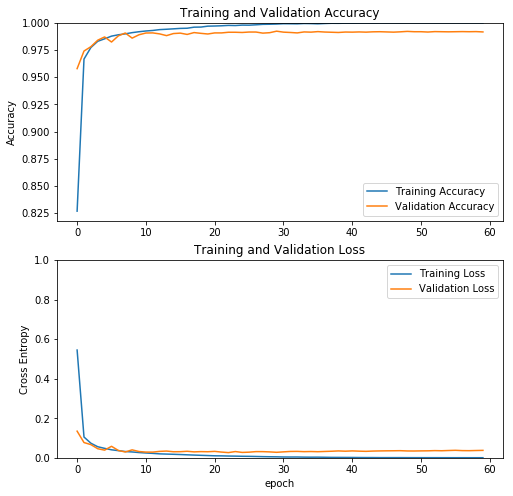

In [35]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1.0])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# DP-SGD

In [12]:
# Define the model using tf.keras.layers
mnist_model_dp = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, 8,
                           strides=2,
                           padding='same',
                           activation='relu'),
    tf.keras.layers.MaxPool2D(2, 1),
    tf.keras.layers.Conv2D(32, 4, strides=2, activation='relu'),
    tf.keras.layers.MaxPool2D(2, 1),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(10)
])

W0905 09:13:58.754631 140216468879232 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [0]:
#tf.compat.v1.disable_eager_execution()

print('l2_norm_clip: %f, noise_multiplier: %f, num_microbatches: %f, learning_rate: %f' 
      % (l2_norm_clip, noise_multiplier, microbatches, learning_rate))
train_data, train_labels, test_data, test_labels = load_mnist()

optimizer = DPGradientDescentGaussianOptimizer(
      l2_norm_clip=l2_norm_clip,
      noise_multiplier=noise_multiplier,
      num_microbatches=microbatches,
      learning_rate=learning_rate)
# Compute vector of per-example loss rather than its mean over a minibatch.
loss = tf.keras.losses.CategoricalCrossentropy(
    from_logits=True, reduction=tf.losses.Reduction.NONE)

# Compile model with Keras
mnist_model_dp.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# Train model with Keras
history_dp = mnist_model_dp.fit(train_data, train_labels,
          epochs=epochs,
          validation_data=(test_data, test_labels),
          batch_size=batch_size)

eps = compute_epsilon(epochs * 60000 // batch_size)
print('For delta=1e-5, the current epsilon is: %.2f' % eps)


l2_norm_clip: 1.000000, noise_multiplier: 1.100000, num_microbatches: 250.000000, learning_rate: 0.150000
11493376/11490434 [==============================] - 0s 0us/step
Train on 60000 samples, validate on 10000 samples


W0905 09:14:00.140654 140216468879232 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/clip_ops.py:286: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0905 09:14:00.171769 140216468879232 deprecation_wrapper.py:119] From /content/privacy/privacy/dp_query/gaussian_query.py:101: The name tf.random_normal is deprecated. Please use tf.random.normal instead.



Epoch 1/60
60000/60000 [==============================] - 74s 1ms/sample - loss: 1.6108 - acc: 0.4669 - val_loss: 0.7662 - val_acc: 0.7470
Epoch 2/60
60000/60000 [==============================] - 69s 1ms/sample - loss: 0.5555 - acc: 0.8246 - val_loss: 0.4085 - val_acc: 0.8750
Epoch 3/60
60000/60000 [==============================] - 69s 1ms/sample - loss: 0.3951 - acc: 0.8869 - val_loss: 0.3562 - val_acc: 0.9022
Epoch 4/60
 4750/60000 [=>............................] - ETA: 1:04 - loss: 0.4029 - acc: 0.8933

In [0]:
acc_dp = history_dp.history['acc']
val_acc_dp = history_dp.history['val_acc']

loss_dp = history_dp.history['loss']
loss_dp = np.mean(loss_dp, axis=1)
val_loss_dp = history_dp.history['val_loss']
val_loss_dp = np.mean(val_loss_dp, axis=1)
#print(len(np.mean(loss_dp, axis=1)))
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc_dp, label='Training Accuracy')
plt.plot(val_acc_dp, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1.0])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss_dp, label='Training Loss')
plt.plot(val_loss_dp, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [0]:
mnist_model.save('mnist_dp_v1.h5')
mnist_model_van.save('mnist_van_v1.h5')

W0901 08:17:58.566678 139697547024256 hdf5_format.py:110] TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file. You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
W0901 08:17:58.613785 139697547024256 hdf5_format.py:110] TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file. You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).


In [0]:
!ls

CONTRIBUTING.md  mnist_van_v1.h5   README.md	     setup.py
LICENSE		 privacy	   requirements.txt  tutorials
mnist_dp_v1.h5	 privacy.egg-info  research


#Exploring the models

Loading up pretrained models...

In [6]:
mnist_model_van = tf.keras.models.load_model("mnist_van_v1.h5")
mnist_model_dp = tf.keras.models.load_model("mnist_dp_v1.h5")

train_data, train_labels, test_data, test_labels = load_mnist()

W0905 05:10:18.516639 140267049281408 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0905 05:10:18.786172 140267049281408 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.


11493376/11490434 [==============================] - 0s 0us/step


Filtering list of images where both vanilla model and DP model **predict correctly**

In [0]:
correct = []
j=0
for i, im in enumerate(train_data):
  if j==rows*columns: break
  im = np.array([im])
  if (np.argmax(mnist_model_dp.predict(im)) == np.argmax(train_labels[i])) and \
  (np.argmax(mnist_model_van.predict(im)) == np.argmax(train_labels[i])):
    j += 1
    correct.append((np.argmax(train_labels[i]), im))

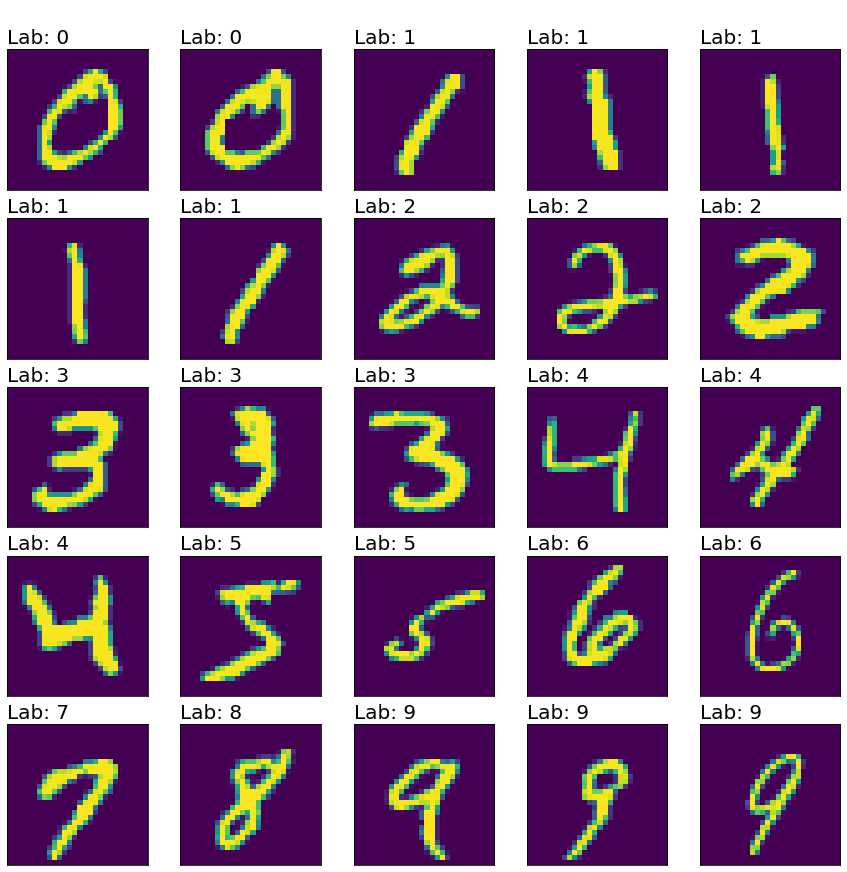

In [14]:
correct.sort(key=lambda tup: tup[0])
fig = plt.figure(figsize=(15, 15))
columns = 5
rows = 5
for i, (l, im) in enumerate(correct):
  ax = fig.add_subplot(rows, columns, i+1)
  ax.set_title("\nLab: " + str(l), loc='left', size=20)
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  plt.imshow(im[0][:,:,0])
plt.show()

Filtering for list of images where vanilla model predicted correctly but **DP model predicted wrongly**

In [0]:
mispredicted = []
j=0
for i, im in enumerate(train_data):
  if j==rows*columns: break
  im = np.array([im])
  if (np.argmax(mnist_model_dp.predict(im)) != np.argmax(train_labels[i])) and \
  (np.argmax(mnist_model_van.predict(im)) == np.argmax(train_labels[i])):
    j += 1
    mispredicted.append((np.argmax(train_labels[i]), np.argmax(mnist_model_dp.predict(im)), im))

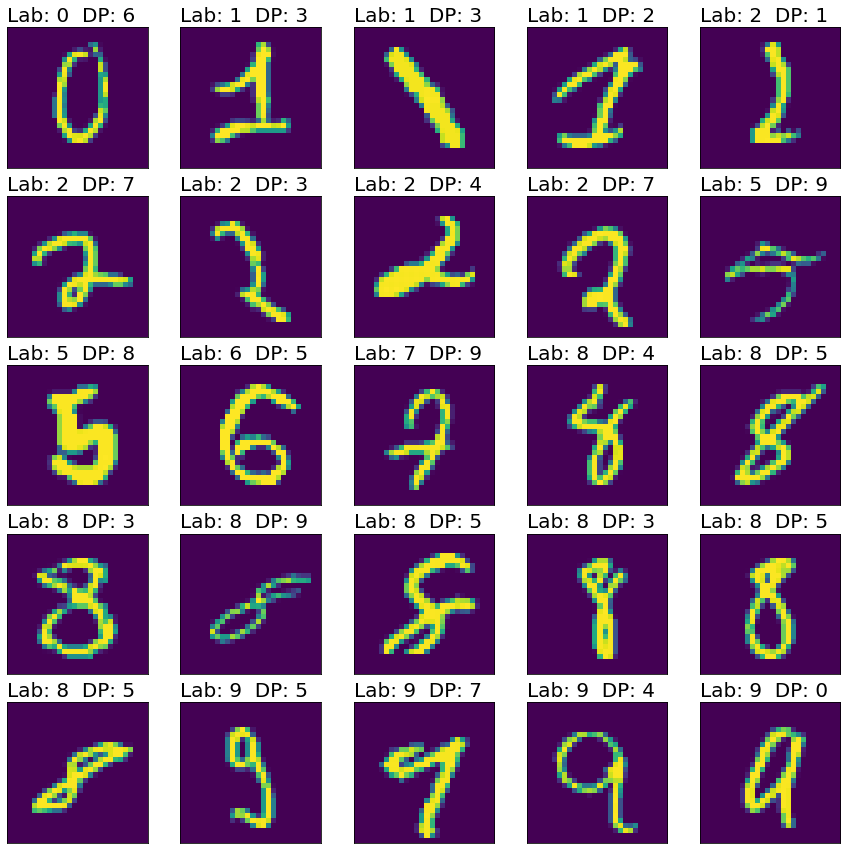

In [19]:
mispredicted.sort(key=lambda tup: tup[0])
fig = plt.figure(figsize=(15, 15))
columns = 5
rows = 5
for i, (l, dp, im) in enumerate(mispredicted):
  ax = fig.add_subplot(rows, columns, i+1)
  ax.set_title("Lab: " + str(l) + "  DP: " + str(dp), 
               loc='left', size=20)
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  plt.imshow(im[0][:,:,0])
plt.show()